In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import control as control
from scipy.signal import butter, lfilter, freqz,lfilter_zi
from tabulate import tabulate
from scipy import signal
from asyncio.windows_events import NULL
from sklearn.metrics import r2_score



In [2]:
def lessVariation(dados,col):
    dados.sort_values(by=col)
    order  = np.array(dados[col].values)
    number_before = math.inf
    deltaMin = math.inf
    for number in order:
        delta = abs(number - number_before)
        deltaMin = delta if (delta != 0 and delta < deltaMin) else deltaMin
        number_before = number
    return deltaMin
        


In [3]:
def butter_lowpass(cutoff_low, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff_low / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    zi = lfilter_zi(b, a)
    y,z0 = lfilter(b, a, data,zi=zi*max(data))
    return y

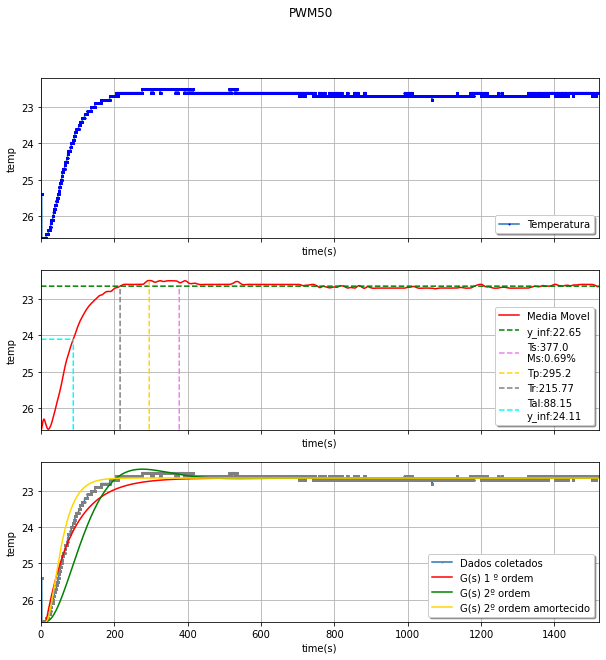

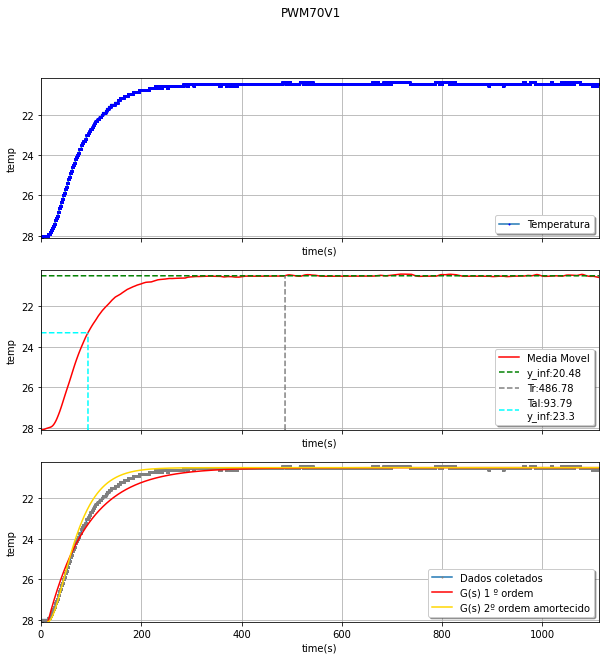

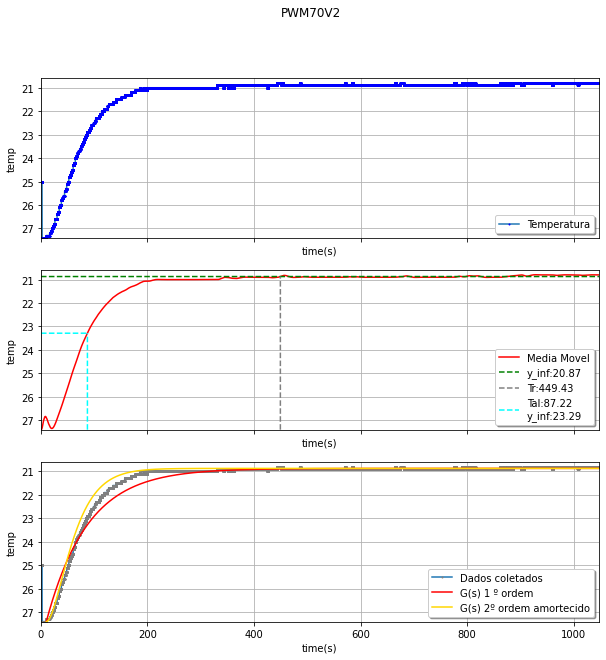

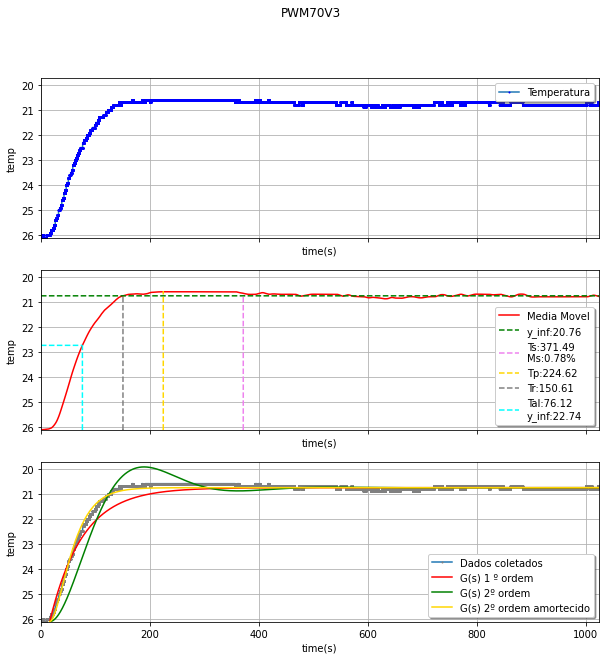

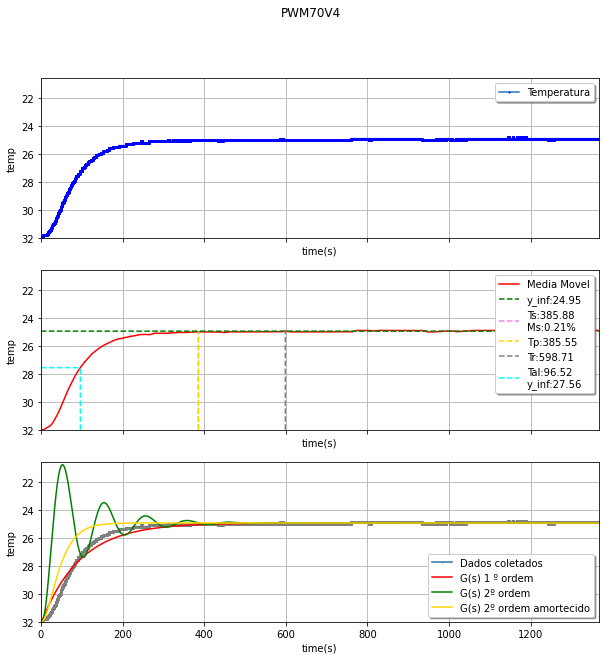

╒══════════╤═════════════════╤═════════════╤═════════════════════════════╤═════════════════════════════╕
│ Degrau   │   atraso(e^-as) │ 1 º ordem   │ 2 º ordem                   │ 2º ordem amortecido         │
╞══════════╪═════════════════╪═════════════╪═════════════════════════════╪═════════════════════════════╡
│ 30       │            4.01 │ -0.0009374  │ -0.0008941                  │ -3.297e-05                  │
│          │                 │ ----------- │ -------------------------   │ --------------------------- │
│          │                 │ s + 0.01495 │ s^2 + 0.01146 s + 0.01426   │ s^2 + 0.04586 s + 0.0005257 │
├──────────┼─────────────────┼─────────────┼─────────────────────────────┼─────────────────────────────┤
│ 50       │           14.07 │ -0.001067   │ -2.022e-05                  │ -0.0001424                  │
│          │                 │ ----------  │ --------------------------- │ --------------------------  │
│          │                 │ s + 0.0135  │ s^2 + 0.02

In [6]:
path = '../Dados/31KHz/'
cutoff_low = 0.04
order = 3
s = control.tf('s')
def dynamics ():
    table = [[ 'Degrau','atraso(e^-as)','1 º ordem',  '2 º ordem','2º ordem amortecido']]
    for diretorio, subpastas, arquivos in os.walk(path):
        for arquivo in arquivos:
            DEGRAU = float(arquivo[3:5])
            G1 = NULL
            G2 = NULL
            csi_cal = NULL
            G2CritiAmo = NULL
            fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharey=True, sharex= True)
            bd = pd.read_csv(os.path.join(diretorio, arquivo), delimiter=';')
            temp  = np.array(bd['temp'].values)
            time = np.array(bd['time(s)'].values)
            mindel = lessVariation(bd,'temp')
            ax1.plot(time, temp,marker="o", markersize=1, markeredgecolor="blue", label='Temperatura')
            ax3.plot(time, temp,marker="o", markersize=1, markeredgecolor="grey", label='Dados coletados')
            #
            ## Media Movel
            fs = len(time)/(time[len(time)-1])
            tmm =butter_lowpass_filter(temp, cutoff_low, fs, order)# bd['temp'].rolling(4).mean().replace(np.nan, temp_init) # temperatura filtada
            temp_init = max(tmm)
            
            util_timeDelay = np.where(abs(temp_init - temp) < mindel)[0]
            indice_timeDelay = util_timeDelay[len(util_timeDelay)-1]
            time_delay =  time[indice_timeDelay]

            ax2.plot(time, tmm, color='r', label='Media Movel') 
            #
            ## Estabilização y_inf
            init_est = np.where(time >= 400)[0][0]
            y_inf = np.mean(tmm[init_est:])
            ax2.plot(time, y_inf*np.ones(len(temp)),'--', color='g',label='y_inf:{}'.format(round(y_inf,2)))
            #
            ## Tempo de subida
            util_tr = np.where(tmm <= y_inf )[0]
            indice_tr = util_tr[0]
            tr = time[indice_tr]
            #
            ## Maximo sobresinal e tempo de pico
            temp_min = min(tmm[:init_est])
            indice_temp_min = np.where(tmm == temp_min )[0][0]
            max_sobr =abs(((temp_min  - y_inf) / y_inf) *100.0)
            if(max_sobr>0.125):
                #
                ## Tempo de estabilixação
                # util_ts = np.where(tmm[:init_est] < (y_inf*0.95 + temp_min*0.05))[0]
                util_ts = np.where((tmm[indice_temp_min:] > (y_inf - mindel)) & (tmm[indice_temp_min:] < (y_inf+ mindel)))[0]## faixa de 0,5% de Y no inf
                indice_ts = util_ts[0] + indice_temp_min

                ts = time[indice_ts]
                # if(ts<tr):
                #     ts = tr
                #     tr = time[indice_ts]
                ax2.plot(ts*np.ones(indice_tr), tmm[:indice_tr],'--', color='violet',markersize=2,label='Ts:{}\nMs:{}%'.format(round(ts,2), round(max_sobr,2) ))
                ## Tempo de pico
                tmmRound = np.round(tmm[:indice_ts], 4) 
                util_tp = np.where(tmmRound == round(temp_min,4))[0]
                indice_tp = round((util_tp[0]+util_tp[len(util_tp)-1])*0.5)##indice medio da temperattura minima da regiao de transição
                tp = time[indice_tp]
                #ax2.text(tp,temp_min -0.35, 'Tp:{}'.format(round(tp,2)))
                ax2.plot(tp*np.ones(indice_tp), tmm[:indice_tp],'--', color='gold',label='Tp:{}'.format(round(tp,2)))
                #
                ##calculo da planta de segunda prdem
                csi_cal = math.cos(math.pi*(1- tr/tp))
                Wn = 4/( ts * csi_cal)
                G2 = ((Wn**2)*((y_inf - temp_init)/DEGRAU))/ ((s**2) + (2*csi_cal*Wn*s) + (Wn**2))
            else:
                ts = tr
            ax2.plot(tr*np.ones(indice_tr), tmm[:indice_tr],'--', color='grey',label='Tr:{}'.format(round(tr,2)))
            #super amortecido
            Wn = 16/( ts )
            G2CritiAmo = ((Wn**2)*((y_inf - temp_init)/DEGRAU))/ ((s**2) + (2*Wn*s) + (Wn**2))        
            
            y_inf63p = y_inf + ((temp_init - y_inf )*0.37)
            indice_tal = np.where(tmm <= (y_inf63p))[0][0]
            tal =  time[indice_tal]
            ax2.plot(tal*np.ones(indice_tal), tmm[:indice_tal],'--', color='aqua',label='Tal:{}\ny_inf:{}'.format(round(tal,2),round(y_inf63p,2)))
            ax2.plot(time[:indice_tal], y_inf63p*np.ones(indice_tal),'--', color='aqua')
            ## calculo da planta para primeira ordem
            a = 1/(tal- time_delay)
            k = (( y_inf - temp_init  )*a)/DEGRAU
            G1 =  (k/(s + a))
            
            ##propriedades do grafico em s
            maxG = temp_init
            minG = min(tmm)
            for (G, labelG, cor) in [(G1, 'G(s) 1 º ordem', 'r'),(G2,'G(s) 2º ordem', 'g'), (G2CritiAmo, 'G(s) 2º ordem amortecido', 'gold')]:
                if (G!=NULL):
                    dt = 0.01 # passo da simulação
                    nt = int ( max(time) / dt ) + 1 # Number of points of sim time
                    t = np.linspace(0,max(time),nt)
                    u = DEGRAU * np.ones(nt)
                    T,Y= control.forced_response(G,t,u , X0 =0.0)# odint
                    Y = Y + temp_init 
                    T = T + time_delay
                    ax3.plot(T, Y, color=cor, label=labelG)
                    maxY = max(Y)
                    minY = min(Y)
                    maxG = maxG if maxG > maxY else maxY
                    minG = minG if minG < minY else minY
            ##propriedades do grafico
            for ax in [ax1,ax2,ax3]:
                ax.set_xlabel('time(s)')
                ax.set_ylabel('temp')
                ax.grid(True)
                ax.legend(shadow=True, fancybox=True)
            fig.suptitle(arquivo[:arquivo.find('.')])
            plt.xlim([0, time[len(time)-1]])
            plt.ylim([maxG + 0.01, minG - 0.2])
            plt.rcParams['figure.figsize'] = [10, 10] 
            plt.show()
            table.append([arquivo[3:arquivo.find('.')],time_delay,G1,G2 if (G2!=NULL) else 0, G2CritiAmo ])
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    return table
table = np.transpose(dynamics())


In [6]:
#quanto mais proximo de 1 melhor
def magnitude(vector): 
    return math.sqrt(sum(pow(element, 2) for element in vector))
def RQuadrado(dataPoints,dataexpected,xdelay):
    [xpoints, ypoints] = dataPoints
    [xexpected, yexpected] = dataexpected
    Ypoints = []
    Yeq = []
    for i in range(0,len(xpoints)):
        if(xpoints[i]>=xdelay):
            iexp = np.where(xpoints[i] == np.round(xexpected,2))[0][0]
            Ypoints.append(ypoints[i])
            Yeq.append(yexpected[iexp])
    # return (r2_score ( Ypoints, Yeq ))
    return (magnitude(np.array(Ypoints) - np.array(Yeq) ))
##TESTE AND VALIDATION
dataPoints = [[-2,-1,1,4],[-3,-1,2,3]]
x = np.linspace(-5,5,11)
y = ((41/42)*x) -(5/21)
dataexpected = [x,y]
print(np.round(RQuadrado(dataPoints,dataexpected,-4),2))
# print('sucess: ',np.round(RQuadrado(dataPoints,dataexpected,-4),2) == 0.12 )
    

1.65


In [7]:
def meanTs (functions):
    zsum = 0
    psum = 0
    ksum = 0
    for fs in functions:
        if(fs !=0):
            z, p, k = signal.tf2zpk(fs.num[0][0], fs.den[0][0])
            zsum += z
            psum += p
            ksum += k
    lemfs = np.count_nonzero(functions)
    mean = signal.ZerosPolesGain(zsum/lemfs, psum/lemfs, ksum/lemfs).to_tf()
    return control.tf(mean.num, mean.den)

In [8]:
table_erro = []
linedelay = table[1,1:]
linedelay = np.append(linedelay,np.mean(table[1,1:]))

for line in table[2:,1:]:
    line = np.append(line,meanTs(line))
    j=0
    for G in line:
        if(G != 0):
            erro_q = [G]
            for diretorio, subpastas, arquivos in os.walk(path):
                for arquivo in arquivos:
                    DEGRAU = float(arquivo[3:5])
                    bd = pd.read_csv(os.path.join(diretorio, arquivo), delimiter=';')
                    mindel = lessVariation(bd,'temp')
                    temp  = np.array(bd['temp'].values)
                    time = np.array(bd['time(s)'].values)
                    fs = len(time)/(time[len(time)-1])
                    tmm =butter_lowpass_filter(temp, cutoff_low, fs, order)
                    temp_init = max(tmm)
                    time_delay = linedelay[j]
                    dt = 0.01 # passo da simulação
                    nt = int ( max(time) / dt ) + 1 # Number of points of sim time
                    t = np.linspace(0,max(time),nt)
                    u = DEGRAU * np.ones(nt)
                    T,Y= control.forced_response(G,t,u , X0 =0.0)
                    Y = Y + temp_init 
                    T = T + time_delay
                    erro_q.append((RQuadrado([time,temp],[T,Y],time_delay)))
            erro_q.append(np.sum(erro_q[1:])/len(erro_q[1:]))
            table_erro.append(erro_q)
        j+=1
table_erro = np.array(table_erro)
tbe_header = ['G(s)']
tbe_header = np.append(tbe_header,table[0,1:])
tbe_header = np.append(tbe_header,'erro medio')
tbe_header = [tbe_header]
table_erro = table_erro[table_erro[:,len(table_erro[0])-1].argsort()]
tbe_header = np.append(tbe_header,table_erro,axis=0)
print(tabulate(tbe_header, headers='firstrow', tablefmt='fancy_grid'))

c:\Python39\lib\site-packages\control\statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
c:\Python39\lib\site-packages\control\statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
c:\Python39\lib\site-packages\control\statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
c:\Python39\lib\site-packages\control\statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
c:\Python39\lib\site-packages\control\statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)
c:\Python39\lib\site-packages\control\statesp.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


╒═════════════════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═════════╤══════════════╕
│ G(s)                        │       30 │       50 │     70V1 │     70V2 │     70V3 │    70V4 │   erro medio │
╞═════════════════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═════════╪══════════════╡
│ -0.000121                   │ 236.539  │ 177.844  │ 277.56   │  43.7518 │ 232.883  │ 167.141 │      189.286 │
│ --------------------------  │          │          │          │          │          │         │              │
│ s^2 + 0.07279 s + 0.001325  │          │          │          │          │          │         │              │
├─────────────────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┼──────────────┤
│ -0.0001182                  │ 252.762  │ 203.741  │ 246.045  │  39.8831 │ 262.87   │ 134.533 │      189.972 │
│ -------------------------   │          │          │          │          │          │         │        

In [5]:
# b = 0.006856
# a =  -0.001209
b = 0.001325
a =  -0.000121 
maior = a/b
print(30+(maior*70))


23.60754716981132
